## Importing Libraries

In [1]:
NAME_OF_MODEL = "bart_programfc"

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import logging
logging.basicConfig(level=logging.ERROR)
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
from transformers import AutoTokenizer,AutoModel

# Load the BERT tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

Loading tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

## Setting up data

In [6]:
import json
with open("/content/drive/MyDrive/TUDelft/NLP Group Project/data/programfc/programfc_train.json") as f:
  train_data = json.load(f)
len(train_data)

1667

In [7]:
train_data[-1]

{'claim_evidence_string': '[Claim]:“More people, aged 18-45, died of Fentanyl overdoses in 2020 than covid, car accidents, cancer, + suicide combined.” [Evidences]:average number of car accidents in the .u.s. every year is 6 million. more than 90 people die in car accidents everyday. 3 million people in the u.s. are ... total number of car accidents per year in the u.s. in the united states, a car accident occurs every 13 minutes, according to the bureau of labor statistics. while technology and new regulations are making vehicles safer, car accidents continue to be a leading cause of death in the u.s. on average, there are over 6 million passenger car accidents in the u.s. every year. road crashes are the leading cause of death in the country, resulting in more than 38,000 people losing their lives each year. the increased ranking of covid-19 as a leading cause of death in some age groups is consistent with a downward age shift in the distribution of covid-19 deaths in the us in 2021 

In [8]:
import json
with open("/content/drive/MyDrive/TUDelft/NLP Group Project/data/programfc/programfc_val.json") as f:
  val_data = json.load(f)
len(val_data)

417

In [9]:
val_data[-1]

{'claim_evidence_string': "[Claim]:A Punjabi news outlet reported that CM Bhagwant Mann has asked for a 3-month leave following his wedding. In the meantime, Raghav Chadha might handle the state’s affairs. [Evidences]:is bhagwant mann (aap candidate) going to be the new cm of punjab state in 2022? ... the business will be run by the son-in-law of kejriwal ie raghav chadha. oct 2, 2023  kejriwal also praised bhagwant mann's government for taking appropriate steps to curb the drug menace in the state. he said the punjab police ... jul 11, 2022  a spokesperson of the chief minister's office said cm bhagwant mann has cleared the file regarding chadha's appointment. we're now on whatsapp. 2022-09-27  as punjab cm bhagwant mann moved the confidence motion, the bjp walks out, while the congress mlas were escorted out. upsssc pet 2022 :        upsssc pet 2022    .  15  16        .   2022                     .        .   2022     37, 58, 209     .       25,11,968   .  12,46,241     . upsssc pet

In [10]:
with open('/content/drive/MyDrive/TUDelft/NLP Group Project/data/programfc/programfc_test.json', 'r') as file:
    test_data = json.load(file)
len(test_data)

522

## Tokenize and save as .pt

In [11]:
from torch.utils.data import TensorDataset
from tqdm import tqdm
from transformers import AutoTokenizer
import torch
import os
from sklearn.preprocessing import LabelEncoder

def tokenize_and_save_dataset(features, labels, tokenizer_short_name, tokenizer_path, dataset_type, le=None):
    """
    Tokenizes the features and saves the dataset as a PyTorch TensorDataset.

    Args:
    features (list): List of feature strings to tokenize.
    labels (list): List of labels corresponding to the features.
    tokenizer_short_name (str): Short name for the tokenizer to use in the filename.
    tokenizer_path (str): Path or name of the tokenizer model.
    dataset_type (str): The type of dataset (train, val, or test) for naming the file.
    le (LabelEncoder, optional): A fitted LabelEncoder. If None, a new one will be created and fitted to the labels.
    """
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, do_lower_case=True)

    input_ids = []
    attention_masks = []

    # Tokenize each feature
    for sent in tqdm(features, desc=f"Tokenizing {dataset_type} features"):
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Encode the labels
    if le is None:
        le = LabelEncoder()
        labels_final = le.fit_transform(labels)
    else:
        labels_final = le.transform(labels)
    labels_final = torch.tensor(labels_final)

    print("Size mismatch?", input_ids.shape[0] , attention_masks.shape[0] , labels_final.shape[0])

    # Create TensorDataset
    dataset = TensorDataset(input_ids, attention_masks, labels_final)

    # Save the dataset
    save_file = os.path.join('/content/drive/MyDrive/TUDelft/NLP Group Project/programfc/', f"{dataset_type}_dataset_tokenized_by_{tokenizer_short_name}.pt")
    torch.save(dataset, save_file)
    print(f"{dataset_type.capitalize()} dataset saved to {save_file}")
    return le  # Return the fitted label encoder for reuse


### Bart

In [12]:
train_labels = [fact["label"] for fact in train_data]
train_features = [fact["claim_evidence_string"] for fact in train_data]

le = tokenize_and_save_dataset(
    features=train_features,
    labels=train_labels,
    tokenizer_short_name='bart',
    tokenizer_path='facebook/bart-large-mnli',
    dataset_type='train'
)
val_labels = [fact["label"] for fact in val_data]
val_features = [fact["claim_evidence_string"] for fact in val_data]

tokenize_and_save_dataset(
    features=val_features,
    labels=val_labels,
    tokenizer_short_name='bart',
    tokenizer_path='facebook/bart-large-mnli',
    dataset_type='val',
    le=le  # Use the fitted LabelEncoder from the training set
)
test_labels = [fact["label"] for fact in test_data]
test_features = [fact["claim_evidence_string"] for fact in test_data]

tokenize_and_save_dataset(
    features=test_features,
    labels=test_labels,
    tokenizer_short_name='bart',
    tokenizer_path='facebook/bart-large-mnli',
    dataset_type='test',
    le=le  # Use the fitted LabelEncoder from the training set
)

Tokenizing train features:   0%|          | 0/1667 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing train features: 100%|██████████| 1667/1667 [00:03<00:00, 550.87it/s]


Size mismatch? 1667 1667 1667
Train dataset saved to /content/drive/MyDrive/TUDelft/NLP Group Project/programfc/train_dataset_tokenized_by_bart.pt


Tokenizing val features:   0%|          | 0/417 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing val features: 100%|██████████| 417/417 [00:00<00:00, 774.91it/s]


Size mismatch? 417 417 417
Val dataset saved to /content/drive/MyDrive/TUDelft/NLP Group Project/programfc/val_dataset_tokenized_by_bart.pt


Tokenizing test features:   0%|          | 0/522 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing test features: 100%|██████████| 522/522 [00:00<00:00, 790.96it/s]

Size mismatch? 522 522 522
Test dataset saved to /content/drive/MyDrive/TUDelft/NLP Group Project/programfc/test_dataset_tokenized_by_bart.pt


LabelEncoder()


# Training setup

In [13]:
# Load the BM25 datasets from the file
dataset = torch.load('/content/drive/MyDrive/TUDelft/NLP Group Project/programfc/train_dataset_tokenized_by_bart.pt')
val_dataset = torch.load('/content/drive/MyDrive/TUDelft/NLP Group Project/programfc/val_dataset_tokenized_by_bart.pt')

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
train_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler(dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [15]:
from torch import nn
class MultiClassClassifier(nn.Module):
    def __init__(self, bart_model_path, labels_count, hidden_dim=768, mlp_dim=500, extras_dim=100, dropout=0.1, freeze_bart=False):
        super().__init__()

        self.bart = AutoModel.from_pretrained(bart_model_path,output_hidden_states=True,output_attentions=True)
        self.dropout = nn.Dropout(dropout)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, mlp_dim),
            nn.ReLU(),
            # nn.Linear(mlp_dim, mlp_dim),
            # # nn.ReLU(),
            # # nn.Linear(mlp_dim, mlp_dim),
            # nn.ReLU(),
            nn.Linear(mlp_dim, labels_count)
        )
        # self.softmax = nn.LogSoftmax(dim=1)
        if freeze_bart:
            print("Freezing layers")
            for param in self.bart.parameters():
                param.requires_grad = False

    def forward(self, tokens, masks):
        output = self.bart(tokens, attention_mask=masks)
        dropout_output = self.dropout(output['last_hidden_state'][:, 0, :])
        # concat_output = torch.cat((dropout_output, topic_emb), dim=1)
        # concat_output = self.dropout(concat_output)
        mlp_output = self.mlp(dropout_output)
        # proba = self.sigmoid(mlp_output)
        # proba = self.softmax(mlp_output)

        return mlp_output

In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Loads BertForSequenceClassification, the pretrained BERT model with a single
num_classes = 3
model = MultiClassClassifier('facebook/bart-large-mnli',3, 1024,768,140,dropout=0.1,freeze_bart=False)

# model.load_state_dict(torch.load("model_bert_difficulty_prediction/model_weights"))

# Tell pytorch to run this model on the GPU.
model.cuda()


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

MultiClassClassifier(
  (bart): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm

## Setting up training loop

In [17]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
from transformers import get_linear_schedule_with_warmup


epochs = 20

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs



In [19]:
len(train_dataloader)

105

In [20]:
1935 * 32

61920

In [21]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [22]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [25]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [26]:
for param in model.bart.encoder.layers[0:5].parameters():
    param.requires_grad=False

In [27]:
loss_func = nn.CrossEntropyLoss()

# Training

In [28]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()
early_stopping = EarlyStopping(patience=2, verbose=True)
# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_accuracy = 0
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questimport gensim.downloader as api
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        # b_poincare = batch[2].to(device)
        # b_difficulty = batch[3].to(device)
        b_labels = batch[2].to(device)
        # skill_labels = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        probas = model(b_input_ids,b_input_mask)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = loss_func(probas, b_labels)
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        # scheduler.step()
        logits = probas.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print(" Train Accuracy: {0:.2f}".format(avg_train_accuracy))

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)



    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)

        b_input_mask = batch[1].to(device)
        # b_poincare = batch[2].to(device)
        # b_difficulty = batch[3].to(device)
        b_labels = batch[2].to(device)
        # skill_labels = batch[3].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.

          logits = model(b_input_ids,b_input_mask)

        # Accumulate the validation loss.
        loss = loss_func(logits, b_labels)
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    output_dir = f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)
    tokenizer.save_pretrained(output_dir)
    torch.save(model.state_dict(), os.path.join(output_dir, 'model_weights'))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...


BartModel is using BartSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


  Batch    40  of    105.    Elapsed: 0:01:47.
  Batch    80  of    105.    Elapsed: 0:03:33.
 Train Accuracy: 0.56

  Average training loss: 0.95
  Training epcoh took: 0:04:36

Running Validation...
  Accuracy: 0.64
Validation loss decreased (inf --> 0.814006).  Saving model ...
  Validation Loss: 0.81
  Validation took: 0:00:45
Saving model to /content/drive/MyDrive/TUDelft/NLP Group Project/bart_programfc-outputs

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    105.    Elapsed: 0:01:46.
  Batch    80  of    105.    Elapsed: 0:03:30.
 Train Accuracy: 0.61

  Average training loss: 0.84
  Training epcoh took: 0:04:33

Running Validation...
  Accuracy: 0.65
EarlyStopping counter: 1 out of 2
  Validation Loss: 0.83
  Validation took: 0:00:24
Saving model to /content/drive/MyDrive/TUDelft/NLP Group Project/bart_programfc-outputs

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    105.    Elapsed: 0:01:45.
  Batch    80  of    105.    Elapsed: 0:03:29.
 Train

# Testing

## Run Test set

In [29]:
from torch.utils.data import DataLoader, RandomSampler

test_dataset = torch.load(f'/content/drive/MyDrive/TUDelft/NLP Group Project/programfc/test_dataset_tokenized_by_bart.pt')
test_dataloader = DataLoader(
            test_dataset,
            batch_size = 16
        )

In [30]:
import torch
import json
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_fscore_support
from collections import defaultdict, Counter

model = MultiClassClassifier('facebook/bart-large-mnli',3, 1024,768,140,dropout=0.1,freeze_bart=False)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs/model_weights'))

if torch.cuda.is_available():
    model.cuda()
    print("Model moved to GPU.")
else:
    print("GPU not available, using CPU.")

model.eval()

batch_size = 16

label_mapping = list(le.classes_)
# label_mapping = ["True", "False", "Conflicting"]

test_taxonomy_labels = [fact["taxonomy_label"] for fact in test_data]
print("test_taxonomy_labels", test_taxonomy_labels)

loss_func = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)

correct = []
incorrect = []
taxonomy_metrics = defaultdict(lambda: defaultdict(list))
overall_true_labels = []
overall_predictions = []

for i, batch in enumerate(tqdm(test_dataloader, desc="Evaluating")):
    batch = tuple(t.cuda() if torch.cuda.is_available() else t for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        logits = model(b_input_ids, b_input_mask)
        predicted_labels = torch.argmax(softmax(logits), dim=1)
          # Now, predicted labels is one hot encoded.
        start_index = i * batch_size
        for j in range(len(b_labels)):
          decoded_sentence = tokenizer.decode(b_input_ids[j], skip_special_tokens=True)
          true_label = label_mapping[b_labels[j].item()]
          predicted_label = label_mapping[predicted_labels[j].item()]
          taxonomy = test_taxonomy_labels[start_index + j]
          result_info = {
            "Tokenizer_decoded": decoded_sentence,
            "Ground_truth": true_label,
            "Predicted_as": predicted_label,
            "Taxonomy": taxonomy
          }
          if (predicted_labels[j] != b_labels[j]):
            incorrect.append(result_info)
          else:
            correct.append(result_info)
    # Store overall predictions and true labels for overall metrics
    overall_predictions.extend(predicted_labels.cpu().numpy())
    overall_true_labels.extend(b_labels.cpu().numpy())

    # Store predictions for each taxonomy
    start_index = i * batch_size
    for j in range(len(b_labels)):
        taxonomy = test_taxonomy_labels[start_index + j]
        taxonomy_metrics[taxonomy]['true'].append(b_labels[j].item())
        taxonomy_metrics[taxonomy]['pred'].append(predicted_labels[j].item())

# Calculate overall metrics
overall_macro_f1 = f1_score(overall_true_labels, overall_predictions, average='macro', zero_division=0)
overall_weighted_f1 = f1_score(overall_true_labels, overall_predictions, average='weighted', zero_division=0)
_, _, overall_f1_per_class, _ = precision_recall_fscore_support(overall_true_labels, overall_predictions, average=None)

# Prepare to collect taxonomy-specific metrics
taxonomy_specific_metrics = {}
for taxonomy, data in taxonomy_metrics.items():
    macro_f1 = f1_score(data['true'], data['pred'], average='macro')
    weighted_f1 = f1_score(data['true'], data['pred'], average='weighted')
    _, _, f1_per_class, _ = precision_recall_fscore_support(data['true'], data['pred'], average=None)
    taxonomy_specific_metrics[taxonomy] = {
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'per_class_f1': f1_per_class
    }

latex_row = "Awesome-Model"
for taxonomy in ["statistical", "temporal", "interval", "comparison"]:
    if taxonomy in taxonomy_specific_metrics:
        latex_row += f" & {taxonomy_specific_metrics[taxonomy]['macro_f1']:.2f} & {taxonomy_specific_metrics[taxonomy]['weighted_f1']:.2f}"
    else:
        latex_row += " & - & -"

# Add per-class F1 scores
latex_row += f" & {overall_f1_per_class[2]:.2f} & {overall_f1_per_class[1]:.2f} & {overall_f1_per_class[0]:.2f}"

# Add overall QUANTemp scores
latex_row += f" & {overall_macro_f1:.2f} & {overall_weighted_f1:.2f} \\\\"

print("\nLatex row:    & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & T-F1 & F-F1 & C-F1 & M-F1 & W-F1 ")
print(latex_row)



Model moved to GPU.
test_taxonomy_labels ['statistical', 'statistical', 'statistical', 'comparison', 'statistical', 'temporal', 'statistical', 'statistical', 'temporal', 'statistical', 'statistical', 'statistical', 'comparison', 'interval', 'interval', 'statistical', 'statistical', 'temporal', 'temporal', 'temporal', 'interval', 'statistical', 'statistical', 'temporal', 'statistical', 'temporal', 'temporal', 'statistical', 'comparison', 'statistical', 'statistical', 'statistical', 'interval', 'statistical', 'temporal', 'temporal', 'temporal', 'interval', 'statistical', 'temporal', 'statistical', 'temporal', 'comparison', 'statistical', 'temporal', 'interval', 'temporal', 'statistical', 'statistical', 'temporal', 'interval', 'comparison', 'statistical', 'interval', 'statistical', 'temporal', 'statistical', 'temporal', 'comparison', 'temporal', 'temporal', 'statistical', 'interval', 'statistical', 'comparison', 'statistical', 'statistical', 'interval', 'comparison', 'statistical', 'stati

Evaluating: 100%|██████████| 33/33 [00:31<00:00,  1.06it/s]


Latex row:    & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & T-F1 & F-F1 & C-F1 & M-F1 & W-F1 
Awesome-Model & 0.44 & 0.55 & 0.32 & 0.67 & 0.45 & 0.67 & 0.37 & 0.37 & 0.10 & 0.80 & 0.42 & 0.44 & 0.59 \\



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save incorrectly classified for qualitative analysis

In [32]:
correct_dump = json.dumps(correct, indent=4)

with open(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs/test_results/{NAME_OF_MODEL}_correctly_classified_test_items.json', 'w') as json_file:
    json_file.write(correct_dump)

incorrect_dump = json.dumps(incorrect, indent=4)

with open(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs/test_results/{NAME_OF_MODEL}_incorrectly_classified_test_items.json', 'w') as json_file:
    json_file.write(incorrect_dump)

## Confusion Matrices

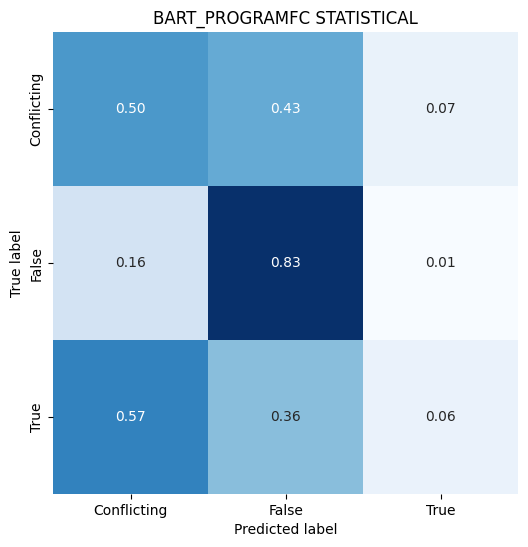

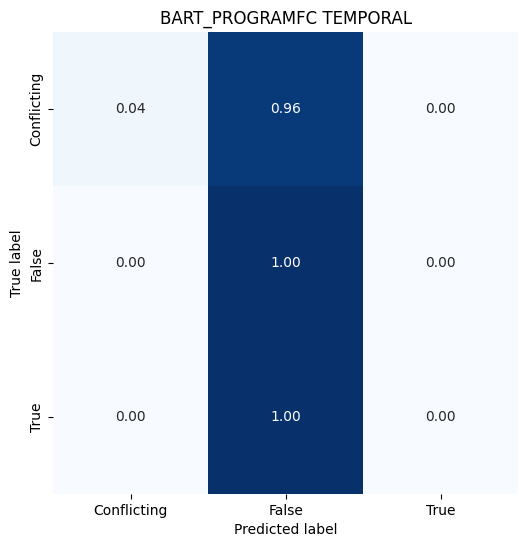

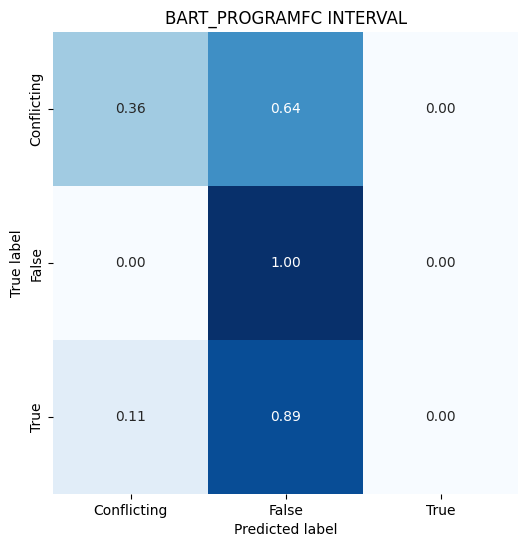

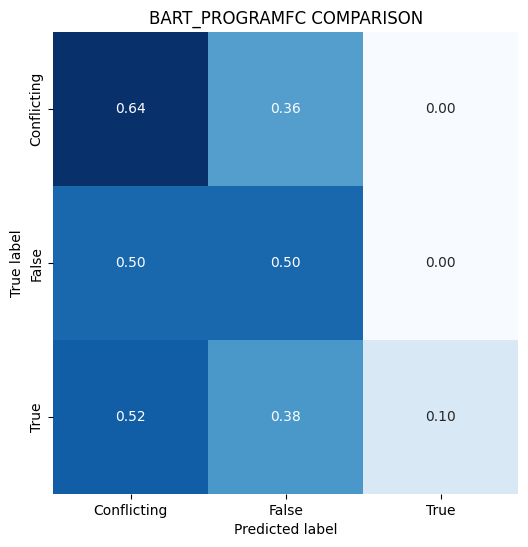

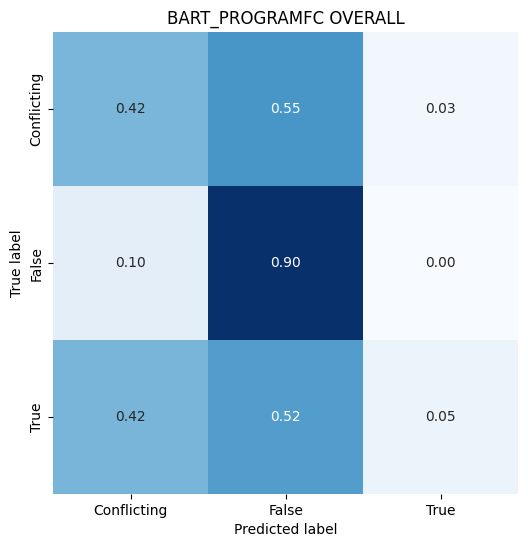

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, class_names, title):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    title (str): Title of the heatmap.
    """
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,6))  # Adjust to fit your needs
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=ax,
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()
    plt.close()  # Close the plot to avoid direct output
    return fig

# Calculate confusion matrices and plot them
categories = ['statistical', 'temporal', 'interval', 'comparison', 'overall']
class_labels = ['Conflicting', 'False', 'True']

# Generate and save confusion matrix plots
for category in categories:
    true_labels = taxonomy_metrics[category]['true'] if category != 'overall' else overall_true_labels
    pred_labels = taxonomy_metrics[category]['pred'] if category != 'overall' else overall_predictions
    cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])

    fig = plot_confusion_matrix(cm, class_labels, f'{NAME_OF_MODEL.upper()} {category.upper()}')
    fig.savefig(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs/confusion_matrices/{NAME_OF_MODEL}_{category}_confusion_matrix.png')  # Save the figure


In [ ]:
from collections import Counter

# Assuming overall_true_labels and overall_predictions are populated
true_label_counts = Counter(overall_true_labels)
predicted_label_counts = Counter(overall_predictions)

# If using LabelEncoder to transform labels, ensure it's fitted as shown previously
label_mapping = list(LE.classes_)  # E.g., ['Conflicting', 'False', 'True']

# Print counts for true labels
print("Counts of each class in the test set:")
for label_index, count in true_label_counts.items():
    print(f"{label_mapping[label_index]}: {count}")

# Print counts for predicted labels
print("\nCounts of each class predicted by the model:")
for label_index, count in predicted_label_counts.items():
    print(f"{label_mapping[label_index]}: {count}")
